In this notebook, we will build a 3D map of a scene from a small set of images and then localize an image downloaded from the Internet. This demo was contributed by [Philipp Lindenberger](https://github.com/Phil26AT/).

In [ ]:
!pip install pycolmap==3.10.0
!git clone --quiet --recursive https://github.com/cjdwd/Hierarchical-Localization/
%cd Hierarchical-Localization
!pip install --progress-bar off --quiet -e .
!pip install --progress-bar off --quiet --upgrade plotly
!pip uninstall pycolamp
!pip install pycolmap==3.10.0


In [ ]:
%load_ext autoreload
%autoreload 2

from pathlib import Path

from hloc import (
    extract_features,
    match_features,
    reconstruction,
    visualization,
    pairs_from_retrieval,
)

In [ ]:
import tqdm, tqdm.notebook
tqdm.tqdm = tqdm.notebook.tqdm  # notebook-friendly progress bars
from pathlib import Path

from hloc import extract_features, match_features, reconstruction, visualization, pairs_from_exhaustive, match_dense
from hloc.visualization import plot_images, read_image
from hloc.utils import viz_3d
import pycolmap
print(pycolmap.__version__)

In [ ]:
!pwd

/content/Hierarchical-Localization


In [ ]:
# Create a new folder named seathru, upload some images
images = Path("../seathru/")

outputs = Path("./")
sfm_pairs = outputs / "pairs-netvlad.txt"
sfm_dir = outputs / "sfm_superpoint+superglue"

retrieval_conf = extract_features.confs["netvlad"]
feature_conf = extract_features.confs["superpoint_aachen"]
matcher_conf = match_features.confs["superglue"]

In [ ]:
# DENSE FEATURE MATCHINING
# Do not run this block if you don't want to use dense feature matching

dense_conf = match_dense.confs['loftr']
features, matches = match_dense.main(dense_conf, sfm_pairs, images, export_dir=outputs)

# Use SuperPoint keypoints as anchors:
feature_conf = extract_features.confs['superpoint_aachen']
features_sp = extract_features.main(feature_conf, images, outputs)
features, matches = match_dense.main(dense_conf, sfm_pairs, images,
                          export_dir=outputs,
                         features_ref=features_sp)

# Localization:
# loc_features, loc_matches = match_dense.main(matcher_conf, loc_pairs,
#      images, export_dir=outputs, features_ref=features, max_kps=None)

model = reconstruction.main(sfm_dir, images, sfm_pairs, features, matches)

[2024/12/06 01:50:25 hloc INFO] Extracting semi-dense features with configuration:
{'cell_size': 1,
 'max_error': 1,
 'model': {'name': 'loftr', 'weights': 'outdoor'},
 'output': 'matches-loftr',
 'preprocessing': {'dfactor': 8, 'grayscale': True, 'resize_max': 1024}}
[2024/12/06 01:50:25 hloc INFO] All pairs exist. Skipping dense matching.
[2024/12/06 01:50:25 hloc INFO] Extracting local features with configuration:
{'model': {'max_keypoints': 4096, 'name': 'superpoint', 'nms_radius': 3},
 'output': 'feats-superpoint-n4096-r1024',
 'preprocessing': {'grayscale': True, 'resize_max': 1024}}
[2024/12/06 01:50:25 hloc INFO] Found 10 images in root ../seathru.
[2024/12/06 01:50:25 hloc INFO] Skipping the extraction.
[2024/12/06 01:50:25 hloc INFO] Extracting semi-dense features with configuration:
{'cell_size': 1,
 'max_error': 1,
 'model': {'name': 'loftr', 'weights': 'outdoor'},
 'output': 'matches-loftr',
 'preprocessing': {'dfactor': 8, 'grayscale': True, 'resize_max': 1024}}
[2024/12/

In [ ]:
retrieval_path = extract_features.main(retrieval_conf, images, outputs)
pairs_from_retrieval.main(retrieval_path, sfm_pairs, num_matched=10)

[2024/12/06 01:41:34 hloc INFO] Extracting local features with configuration:
{'model': {'name': 'netvlad'},
 'output': 'global-feats-netvlad',
 'preprocessing': {'resize_max': 1024}}
[2024/12/06 01:41:34 hloc INFO] Found 10 images in root ../seathru.
100%|██████████| 529M/529M [00:26<00:00, 20.6MB/s]
100%|██████████| 10/10 [00:02<00:00,  4.11it/s]
[2024/12/06 01:42:14 hloc INFO] Finished exporting features.
[2024/12/06 01:42:14 hloc INFO] Extracting image pairs from a retrieval database.
[2024/12/06 01:42:15 hloc INFO] Found 90 pairs.


In [ ]:
#%%
feature_path = extract_features.main(feature_conf, images, outputs)
match_path = match_features.main(
    matcher_conf, sfm_pairs, feature_conf["output"], outputs
)

[2024/12/06 01:24:54 hloc INFO] Extracting local features with configuration:
{'model': {'max_keypoints': 4096, 'name': 'superpoint', 'nms_radius': 3},
 'output': 'feats-superpoint-n4096-r1024',
 'preprocessing': {'grayscale': True, 'resize_max': 1024}}
[2024/12/06 01:24:54 hloc INFO] Found 27 images in root ../../../../seathru_D1_subset_1.
[2024/12/06 01:24:54 hloc INFO] Skipping the extraction.
[2024/12/06 01:24:54 hloc INFO] Extracting semi-dense features with configuration:
{'cell_size': 4,
 'max_error': 4,
 'model': {'name': 'loftr', 'weights': 'outdoor'},
 'output': 'matches-loftr_aachen',
 'preprocessing': {'dfactor': 8, 'grayscale': True, 'resize_max': 1024}}
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might ge

  0%|          | 0/170 [00:00<?, ?it/s]

TypeError: Caught TypeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/worker.py", line 351, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/fetch.py", line 52, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/fetch.py", line 52, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/content/Hierarchical-Localization/hloc/match_dense.py", line 224, in __getitem__
    image0 = read_image(self.image_dir / name0, self.conf.grayscale)
TypeError: unsupported operand type(s) for /: 'str' and 'str'


In [ ]:
model = reconstruction.main(sfm_dir, images, sfm_pairs, feature_path, match_path)

AssertionError: outputs/sfm/seathru/feats-superpoint-n4096-r1024_matches-superglue_pairs-netvlad.h5

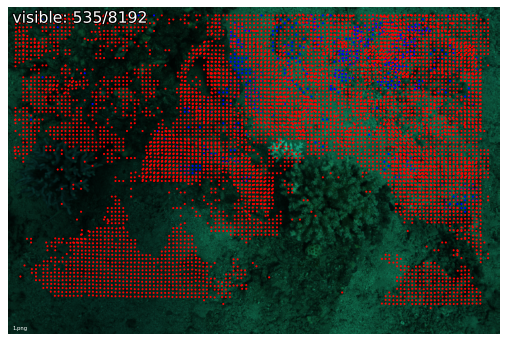

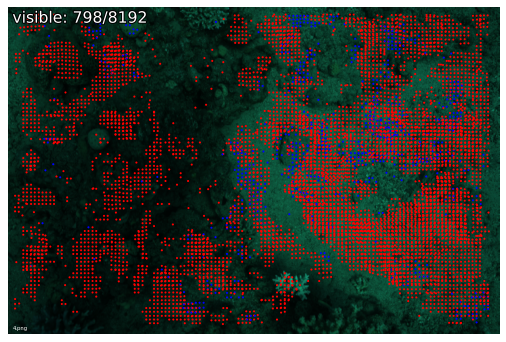

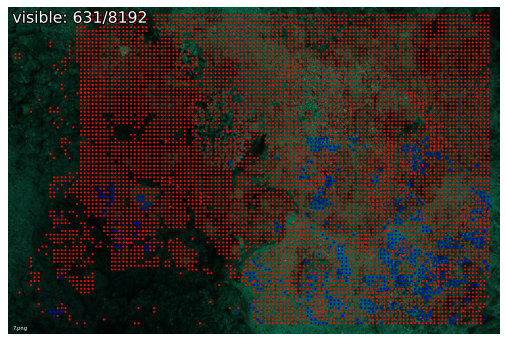

In [ ]:
visualization.visualize_sfm_2d(model, images, color_by="visibility", n=10)

In [ ]:
model.write(outputs)

In [ ]:
import pycolmap

def save_points3D_to_ply(reconstruction, output_file):
    points3D = reconstruction.points3D
    with open(output_file, "w") as f:
        f.write("ply\n")
        f.write("format ascii 1.0\n")
        f.write(f"element vertex {len(points3D)}\n")
        f.write("property float x\n")
        f.write("property float y\n")
        f.write("property float z\n")
        f.write("property uchar red\n")
        f.write("property uchar green\n")
        f.write("property uchar blue\n")
        f.write("end_header\n")

        for point_id, point in points3D.items():
            x, y, z = point.xyz
            r, g, b = point.color
            f.write(f"{x} {y} {z} {r} {g} {b}\n")

    print(f"Point cloud saved to {output_file}")

output_ply_file = images / "points3D.ply"
save_points3D_to_ply(model, output_ply_file)

Point cloud saved to ../seathru/points3D.ply
